In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
filepath = "data/A - AmbulanceCalls.xlsx"

ambulance_train_df = pd.read_excel(filepath, sheet_name='train')
ambulance_test_df = pd.read_excel(filepath, sheet_name='test')

In [3]:
with pd.option_context("display.max_rows", None):
    print(ambulance_train_df)

          date  calls
0   2020-01-06    263
1   2020-01-13    294
2   2020-01-20    332
3   2020-01-27    266
4   2020-02-03    283
5   2020-02-10    412
6   2020-02-17    420
7   2020-02-24    312
8   2020-03-02    240
9   2020-03-09    296
10  2020-03-16    278
11  2020-03-23    495
12  2020-03-30    320
13  2020-04-06    508
14  2020-04-13    470
15  2020-04-20    544
16  2020-04-27    600
17  2020-05-04    634
18  2020-05-11    644
19  2020-05-18    789
20  2020-05-25    638
21  2020-06-01    651
22  2020-06-08    407
23  2020-06-15    653
24  2020-06-22    513
25  2020-06-29    634
26  2020-07-06    546
27  2020-07-13    481
28  2020-07-20    615
29  2020-07-27    578
30  2020-08-03    559
31  2020-08-10    455
32  2020-08-17    440
33  2020-08-24    417
34  2020-08-31    370
35  2020-09-07    490
36  2020-09-14    377
37  2020-09-21    417
38  2020-09-28    532
39  2020-10-05    432
40  2020-10-12    388
41  2020-10-19    228
42  2020-10-26    362
43  2020-11-02    391
44  2020-1

In [4]:
ambulance_test_df

,date,calls
0,2023-06-05,449
1,2023-06-12,352
2,2023-06-19,375
3,2023-06-26,432
4,2023-07-03,339
5,2023-07-10,305
6,2023-07-17,551
7,2023-07-24,456
8,2023-07-31,567
9,2023-08-07,582


In [5]:
print(f"Train shape: {ambulance_train_df.shape}")
print(f"Test shape: {ambulance_test_df.shape}")

Train shape: (178, 2)
Test shape: (30, 2)


### Exploratory Data Analysis

1.   Does the data contain any trends? How do you know?
2.   Does the data contain seasonality? How do you know?
    *Cant use: Dickey-Fuller test, Augmented Dickey-Fuller test, KPSS test

3. Were there any major outliers (i.e., large upward or downward spikes)? Should they be included in the forecasting analysis or not? Why?

4. Through your data analysis, determine what type of forecasting methods would be appropriate for use in forecasting future values for the selected dataset.











#### 1. Trend Analysis

[]

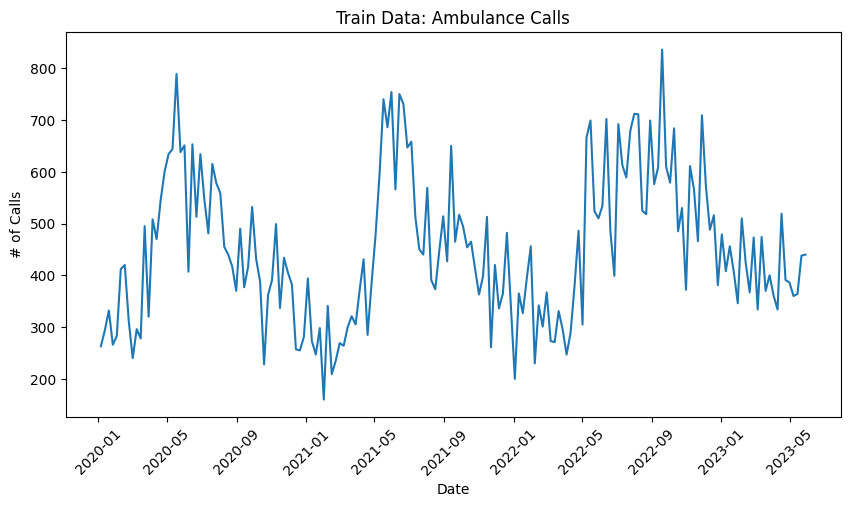

In [6]:
plt.figure(figsize=(10,5))
plt.plot(ambulance_train_df["date"], ambulance_train_df["calls"])
plt.title("Train Data: Ambulance Calls")
plt.xlabel("Date")
plt.ylabel("# of Calls")
plt.xticks(rotation=45)
plt.plot()

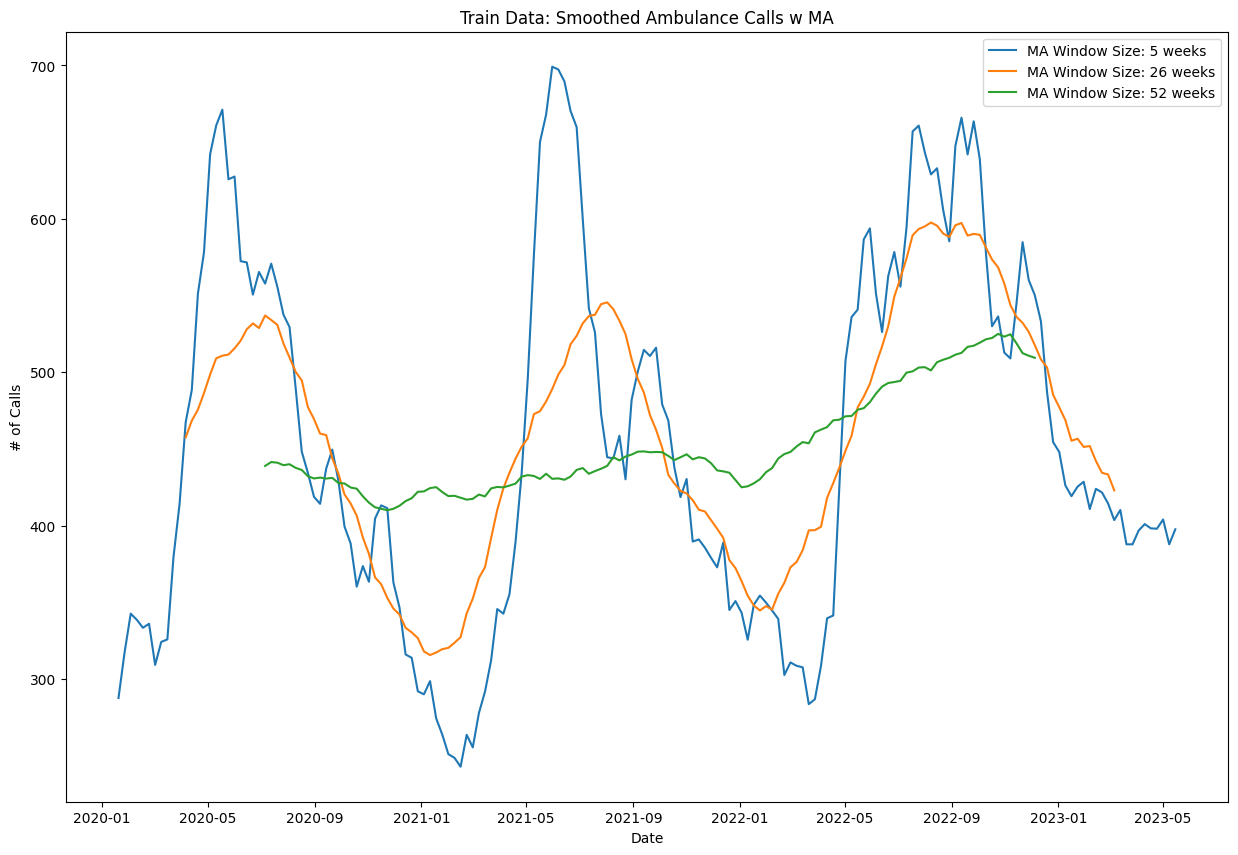

In [7]:
ma_windows = [5,26,52]

fig, ax = plt.subplots(figsize=(15,10))

for window in ma_windows:
    ma_series = ambulance_train_df['calls'].rolling(window=window, center=True).mean()
    ax.plot(ambulance_train_df["date"], ma_series, label=f"MA Window Size: {window} weeks")

ax.set_title("Train Data: Smoothed Ambulance Calls w MA")
ax.set_xlabel("Date")
ax.set_ylabel("# of Calls")
plt.legend()
plt.show()

When we plot the original ambulance call data, we observe clear cycles, but it is difficult to identify any longer term trends. We do notice that the third peak appears slightly broader than the first two suggesting a possible trend.

To better visualize the data and reduce noise, we apply moving averages (MA). Considering the cycles in the data, we looked at typical time frames: each month has approximately 3–5 data points (weeks), while each year has roughly 51–52 data points.

Using these as our sliding windows, we apply MA with windows of 5 (roughly a month) and 52 (roughly a year). We observe that as the MA window increases, the fluctuations smooth out and the underlying trend becomes more apparent. In particular, the yearly MA reveals a gradual upward trend, confirming that a long-term trend exists in the data once seasonality is smoothed out.

#### 2. Seasonality

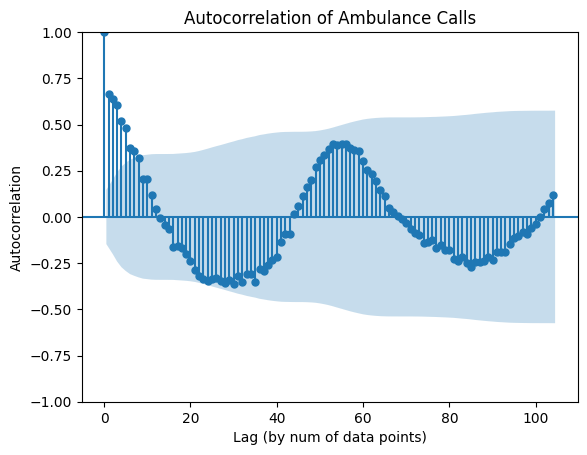

In [8]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(ambulance_train_df['calls'], lags=104) # Compute autocorr for evry lag up to 104
plt.title("Autocorrelation of Ambulance Calls")
plt.xlabel("Lag (by num of data points)")
plt.ylabel("Autocorrelation")
plt.show()

When plotting the raw training data, we can clearly identify cycles, notably: the first cycle from 2020-01 to 2021-01, the second cycle from 2021-01 to 2022-05, and the last cycle from 2022-05 to 2023-05.

To further verify the presence of seasonality, we plot the autocorrelation function (ACF) of the data. From the ACF, we observe that the series exhibits weak autocorrelation with its lagged values, with the strongest correlation of approximately 0.3 at a lag of ~53, which corresponds to roughly one year’s worth of data points, consistent with the cycles identified in the time series. The weak autocorrelation can be the result of the noisy data so to further explore we can retry the acf on the smmothed data (via MA) to find stronger correlation

Also a decay suggests non-stationary (ex: trend)

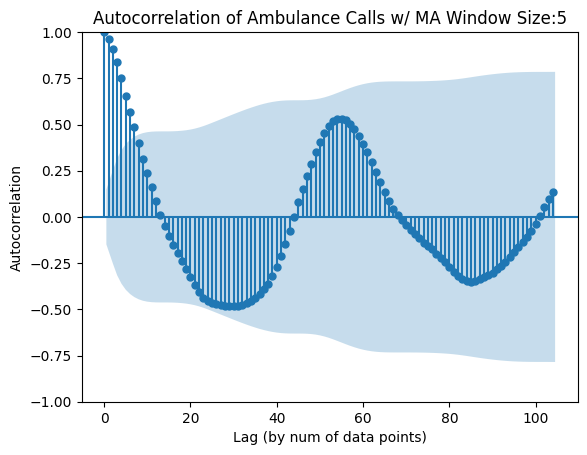

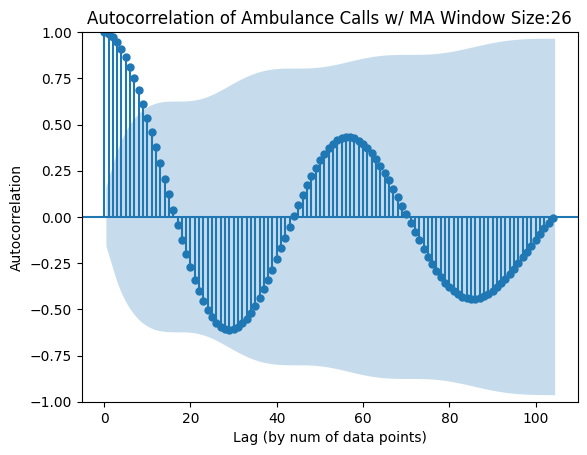

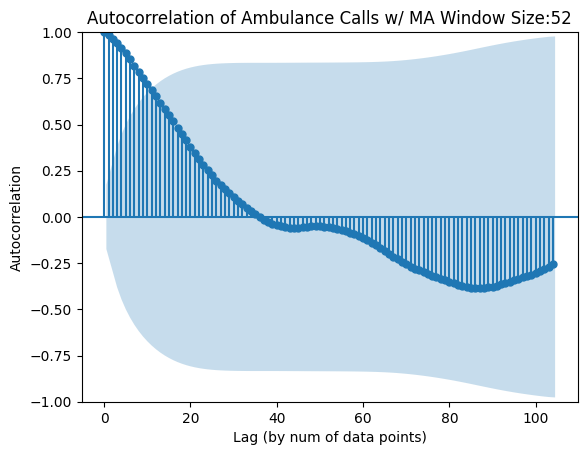

In [9]:
for window in ma_windows:
    ma_series = ambulance_train_df['calls'].rolling(window=window, center=True).mean().dropna()
    plot_acf(ma_series, lags=104) # Compute autocorr for evry lag up to 104
    plt.title(f"Autocorrelation of Ambulance Calls w/ MA Window Size:{window}")
    plt.xlabel("Lag (by num of data points)")
    plt.ylabel("Autocorrelation")
    plt.show()

#### 3. Outlier Analysis

#### Training Data

<Axes: >

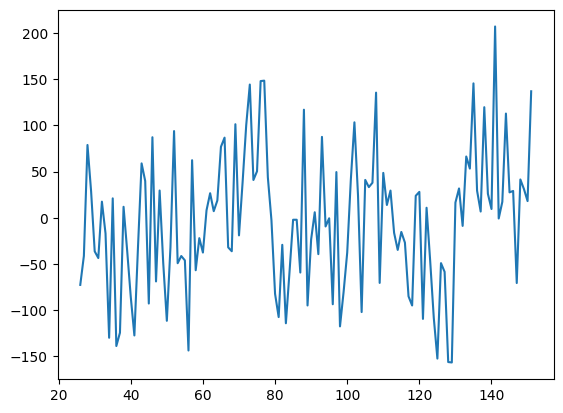

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ambulance_train_df['calls'], model='additive', period=52)
residuals = decomposition.resid.dropna()
residuals.plot()

In [11]:
# Std and mean
resid_mean = residuals.mean()
resid_std = residuals.std()
lower_bound = resid_mean - 3 * resid_std
upper_bound = resid_mean + 3 * resid_std

outliers = residuals[(residuals < lower_bound) | (residuals > upper_bound)]
print(f"Stdeva: {outliers}")

Stdeva: Series([], Name: resid, dtype: float64)


In [12]:
# Quantiles
Q1 = residuals.quantile(0.25)
Q3 = residuals.quantile(0.75)
IQR = Q3 - Q1

robust_lower = Q1 - 1.5 * IQR
robust_upper = Q3 + 1.5 * IQR

outliers_iqr = residuals[(residuals < robust_lower) | (residuals > robust_upper)]

print("Outliers found using Robust IQR:")
print(outliers_iqr)

Outliers found using Robust IQR:
141    207.141211
Name: resid, dtype: float64


The difference between the two methods highlights a statistical property known as "masking." The stdeva method failed to detect any outliers because the extreme spike on September 19 2022 was large enough to inflate the entire datasets stdeva. This inflated value widened the upper boundary significantly that the outlier was effectively hidden within the expanded definition of "normal." 

The IQR method is robust to extreme values because it constructs boundaries based on the middle 50% of the data. By ignoring the extremes during calculation, the IQR method correctly identified the residual of approximately 207 as a statistically significant anomaly that the standard deviation method missed.

### Forecasting

#### 1. Triple Exponential Smoothing

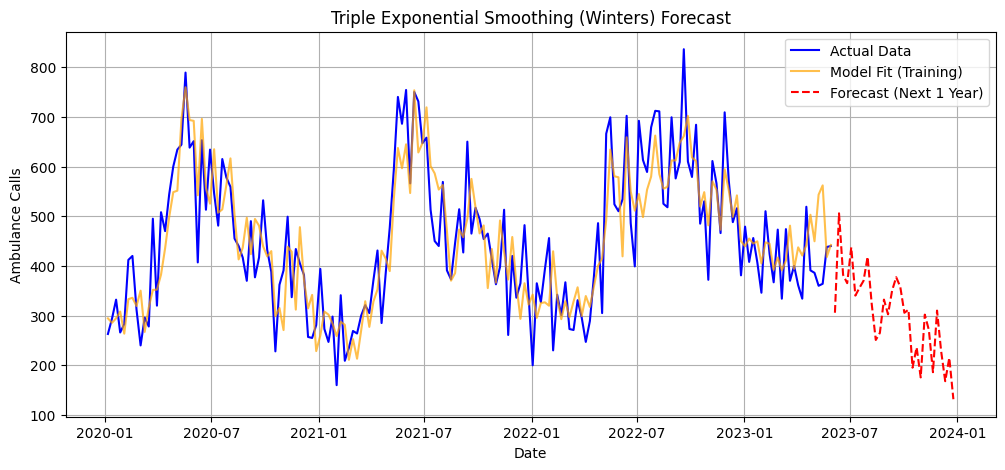

In [50]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(
    ambulance_train_df['calls'], 
    trend='add', 
    seasonal='add', 
    seasonal_periods=52
)

fitted_model = model.fit()

forecast_steps = len(ambulance_test_df)
forecast = fitted_model.forecast(steps=forecast_steps)
forecast.index = ambulance_test_df['date']

plt.figure(figsize=(12, 5))
plt.plot(ambulance_train_df['date'], ambulance_train_df['calls'], label='Actual Data', color='blue')
plt.plot(ambulance_train_df['date'], fitted_model.fittedvalues, label='Model Fit (Training)', color='orange', alpha=0.7)
plt.plot(forecast.index, forecast, label='Forecast (Next 1 Year)', color='red', linestyle='--')
plt.title('Triple Exponential Smoothing (Winters) Forecast')
plt.xlabel('Date')
plt.ylabel('Ambulance Calls')
plt.legend()
plt.grid(True)
plt.show()

In [51]:
print(fitted_model.params)

{'smoothing_level': np.float64(0.3439775269964311), 'smoothing_trend': np.float64(0.0), 'smoothing_seasonal': np.float64(0.0), 'damping_trend': nan, 'initial_level': np.float64(412.89691008008526), 'initial_trend': np.float64(-0.7146553963735788), 'initial_seasons': array([-117.81714725, -115.19361263, -108.42066706, -106.96610143,
       -136.18042156,  -72.77243343,  -96.47618158, -141.32399521,
       -107.138049  , -151.56433581, -111.50299539,  -62.29058833,
       -110.40306718,  -68.42615702,  -57.92039534,   -6.18956165,
         28.91693268,   14.81602978,  131.1129871 ,  213.59533577,
        138.20202691,  156.31199076,   21.38500295,  222.16404925,
         98.92920794,   83.00168658,  155.77155831,   59.39955497,
         75.6259786 ,   90.63864146,  139.64205178,   45.85701489,
        -26.29395155,  -11.35244952,   56.38944555,   27.49370218,
         76.18009271,  103.57253344,   84.80055299,   33.44084114,
         40.33867805,  -75.56794226,  -34.01092493,  -93.767502

The TES Winters model optimized to a smoothing level of 0.37, indicating moderate responsiveness to recent changes. Notably, both trend and seasonal smoothing were 0.0, indicating that the underlying seasonal structure (Winter Lows/Summer Highs) is highly stable and does not evolve significantly over time. The seasonal factors confirm this, showing that peak summer weeks consistently.

In [52]:
from sklearn.metrics import mean_absolute_error

mape = mean_absolute_error(ambulance_train_df['calls'], fitted_model.fittedvalues)
print("MAE on fitted training data:", mape)

MAE on fitted training data: 63.00824924211579


#### 2. ARIMA

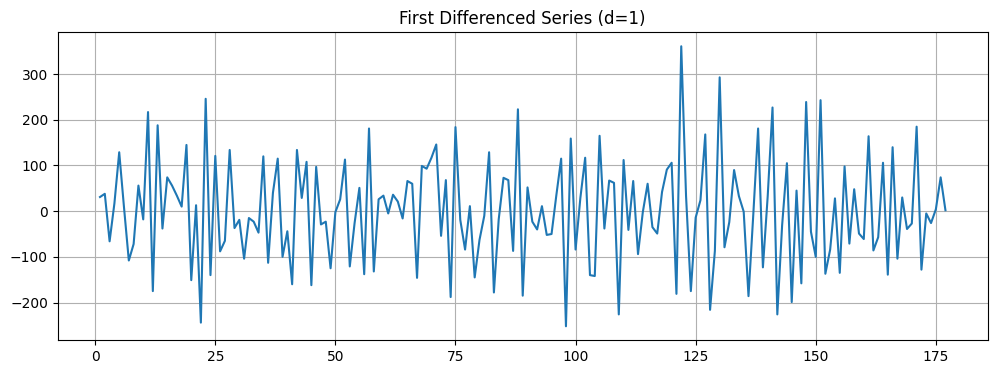

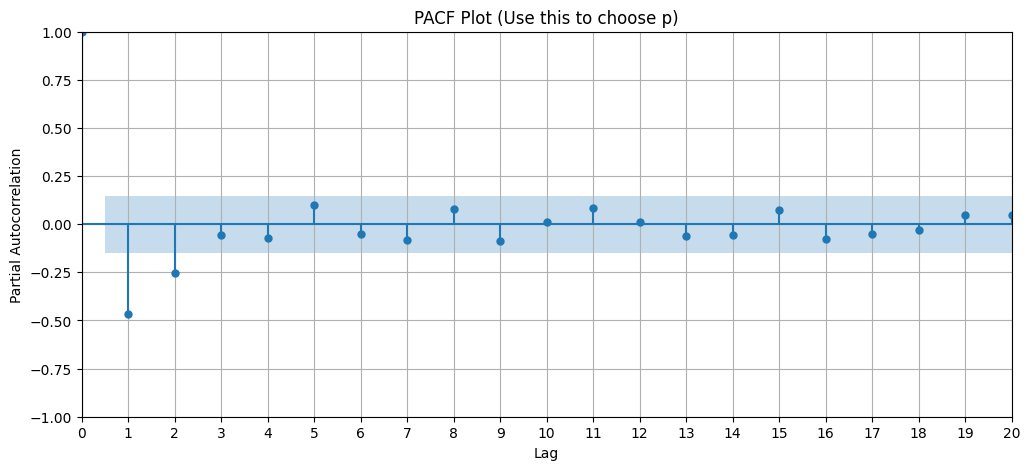

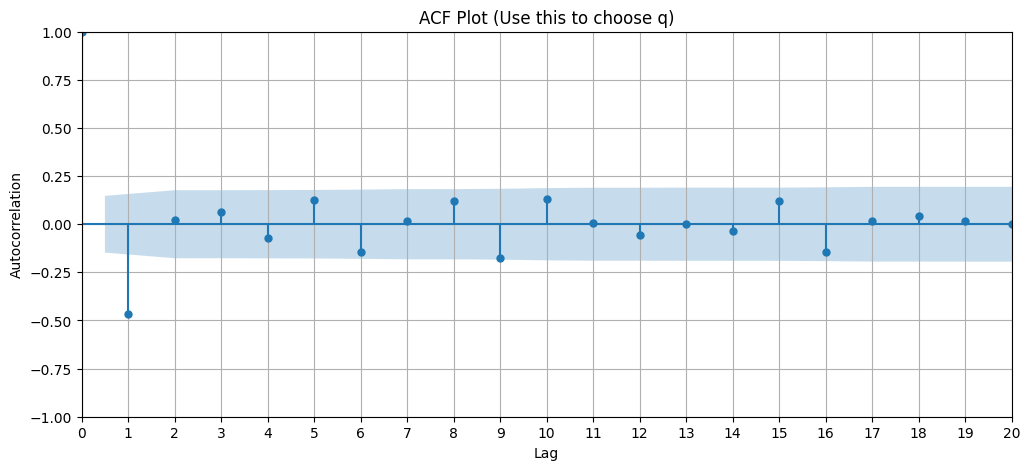

In [53]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# First Difference -> d=1
diff_series = ambulance_train_df['calls'].diff().dropna()
plt.figure(figsize=(12,4))
plt.plot(diff_series)
plt.title("First Differenced Series (d=1)")
plt.grid(True)
plt.show()

# PACF -> p
fig, ax = plt.subplots(figsize=(12,5))
plot_pacf(diff_series, lags=20, method='ywm', ax=ax)
ax.set_xlim(0, 20)
ax.set_xticks(np.arange(0, 21, 1))
ax.grid(True, axis='both')
ax.set_xlabel("Lag")
ax.set_ylabel("Partial Autocorrelation")
ax.set_title("PACF Plot (Use this to choose p)")
plt.show()

# ACF -> q
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(diff_series, lags=20, ax=ax)
ax.set_xlim(0, 20)
ax.set_xticks(np.arange(0, 21, 1))
ax.grid(True, axis='both')
ax.set_xlabel("Lag")
ax.set_ylabel("Autocorrelation")
ax.set_title("ACF Plot (Use this to choose q)")
plt.show()

We choose p = 2 and q = 1 and d = 1

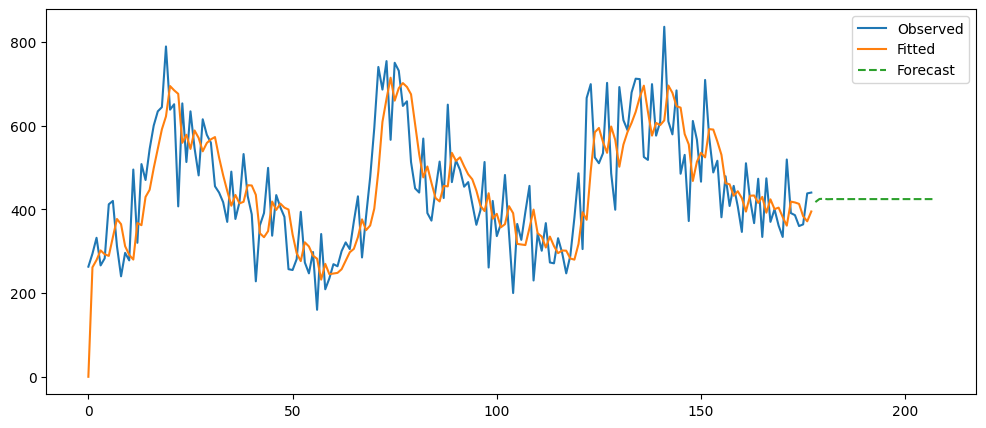

                               SARIMAX Results                                
Dep. Variable:                  calls   No. Observations:                  178
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -1062.943
Date:                Sat, 14 Feb 2026   AIC                           2133.885
Time:                        23:44:02   BIC                           2146.590
Sample:                             0   HQIC                          2139.038
                                - 178                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3360      0.251     -1.341      0.180      -0.827       0.155
ar.L2         -0.1347      0.150     -0.900      0.368      -0.428       0.159
ma.L1         -0.2665      0.249     -1.069      0.2

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(ambulance_train_df['calls'], order=(2, 1, 1))
arima_fitted = arima_model.fit()
forecast_arima = arima_fitted.forecast(steps=30)

plt.figure(figsize=(12,5))
plt.plot(ambulance_train_df['calls'], label='Observed')
plt.plot(arima_fitted.fittedvalues, label='Fitted')
plt.plot(forecast_arima, label='Forecast', linestyle= '--' )
plt.legend()
plt.show()

print(arima_fitted.summary())

In [56]:
mae = mean_absolute_error(ambulance_train_df['calls'], arima_fitted.fittedvalues)
print("MAE:", mae)

MAE: 79.65246552845532


#### Grid Search with SARIMAX

In [16]:
import pmdarima as pm

ambulance_train_df['date'] = pd.to_datetime(ambulance_train_df['date'])
ambulance_test_df['date'] = pd.to_datetime(ambulance_test_df['date']) 

arima_model = pm.auto_arima(
    ambulance_train_df['calls'],
    seasonal=True,
    m=52,
    d=1,
    D=1,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True
)

print(arima_model.summary)

forecast_arima = arima_model.predict(n_periods=len(ambulance_test_df))

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[52]             : AIC=inf, Time=4.71 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=1625.037, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=1571.794, Time=0.89 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=inf, Time=2.76 sec
 ARIMA(1,1,0)(0,1,0)[52]             : AIC=1591.998, Time=0.08 sec
 ARIMA(1,1,0)(2,1,0)[52]             : AIC=inf, Time=3.66 sec
 ARIMA(1,1,0)(1,1,1)[52]             : AIC=inf, Time=3.64 sec
 ARIMA(1,1,0)(0,1,1)[52]             : AIC=inf, Time=2.67 sec
 ARIMA(1,1,0)(2,1,1)[52]             : AIC=inf, Time=7.93 sec
 ARIMA(0,1,0)(1,1,0)[52]             : AIC=1601.532, Time=0.64 sec
 ARIMA(2,1,0)(1,1,0)[52]             : AIC=1561.179, Time=1.36 sec
 ARIMA(2,1,0)(0,1,0)[52]             : AIC=1582.692, Time=0.12 sec
 ARIMA(2,1,0)(2,1,0)[52]             : AIC=inf, Time=4.29 sec
 ARIMA(2,1,0)(1,1,1)[52]             : AIC=inf, Time=5.14 sec
 ARIMA(2,1,0)(0,1,1)[52]             : AIC=inf, Time=3.38 s

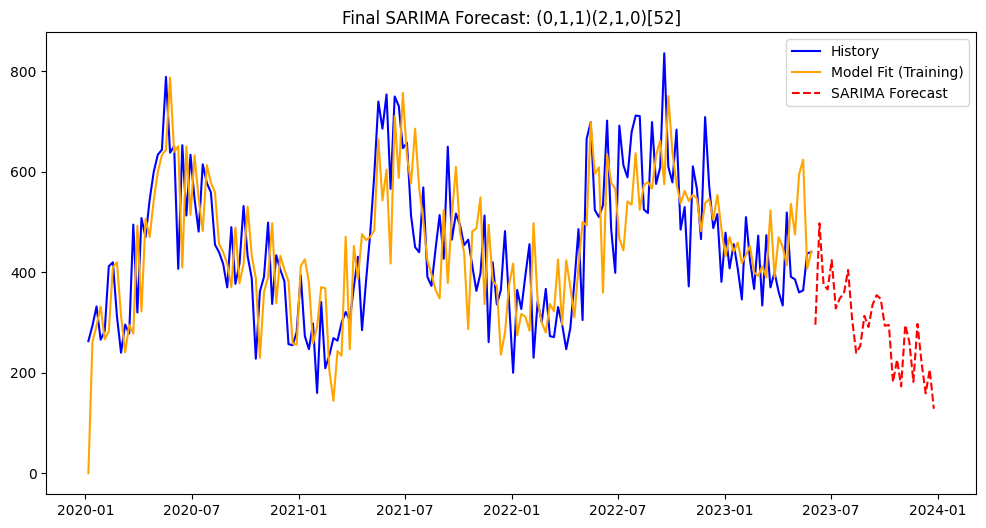

In [39]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# order=(0, 1, 1)
# seasonal_order=(2, 1, 0, 52)
sarima_model = SARIMAX(
    ambulance_train_df['calls'],
    order=(0, 1, 1),
    seasonal_order=(2, 1, 0, 52)
)

results = sarima_model.fit()

forecast_arima = results.get_forecast(steps=len(ambulance_test_df))
predicted_mean = forecast_arima.predicted_mean
predicted_mean.index = ambulance_test_df['date']
fitted_values = results.fittedvalues
fitted_values.index = ambulance_train_df['date']

plt.figure(figsize=(12, 6))
plt.plot(ambulance_train_df['date'], ambulance_train_df['calls'], label='History', color='blue')
plt.plot(fitted_values.index, fitted_values, label='Model Fit (Training)', color='orange')
plt.plot(predicted_mean.index, predicted_mean, label='SARIMA Forecast', color='red', linestyle='--')
plt.title('Final SARIMA Forecast: (0,1,1)(2,1,0)[52]')
plt.legend()
plt.show()

In [ ]:
mae = mean_absolute_error(ambulance_train_df['calls'], fitted_values)
print("MAE on fitted training data:", mae)

MAE on fitted training data: 93.8673065514869


###  Comparison to Actual Data

MAE was selected as the primary metric because it provides a tangible value in "calls per week". For a system like EMS, where resource allocation (# of ambulances) is based on discrete units of demand, MAE offers the most actionable insight into the buffer capacity required to maintain service levels.

### Triple Exponential Smoothing

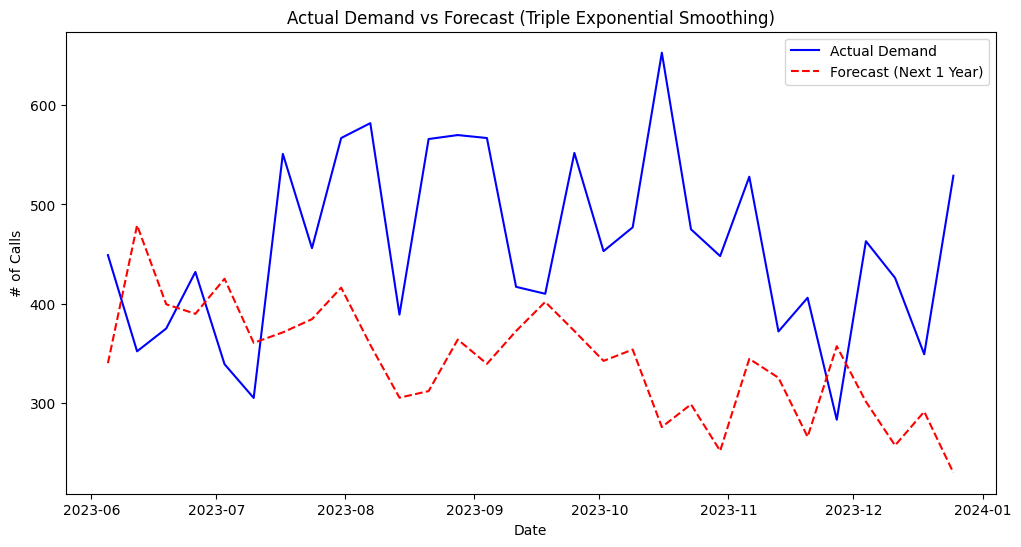

In [28]:
plt.figure(figsize=(12, 6))

plt.plot(ambulance_test_df['date'], ambulance_test_df['calls'], label='Actual Demand', color='blue')
plt.plot(forecast.index, forecast, label='Forecast (Next 1 Year)', color='red', linestyle='--')
plt.title("Actual Demand vs Forecast (Triple Exponential Smoothing)")
plt.xlabel("Date")
plt.ylabel("# of Calls")
plt.legend()
plt.show()

In [36]:
mae = mean_absolute_error(ambulance_test_df['calls'], forecast.values)
print("MAE on test data:", mae)

MAE on test data: 139.68399079764032


### ARIMA

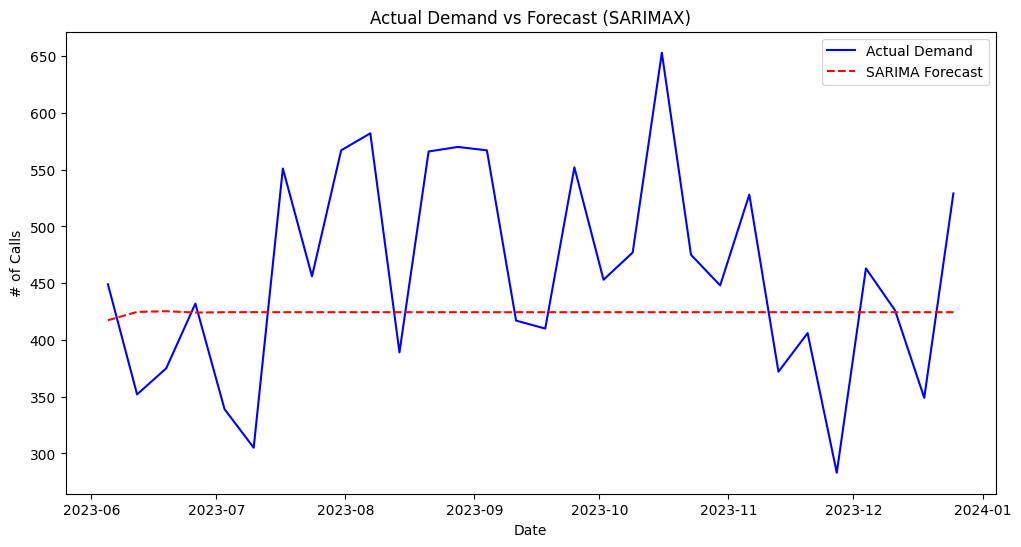

In [ ]:
forecast_values = arima_fitted.forecast(steps=len(ambulance_test_df))
forecast_series = pd.Series(forecast_values.values, index=ambulance_test_df['date'])

plt.figure(figsize=(12, 6))
plt.plot(ambulance_test_df['date'], ambulance_test_df['calls'], label='Actual Demand', color='blue')
plt.plot(forecast_series.index, forecast_series.values, label='SARIMA Forecast', color='red', linestyle='--')
plt.title("Actual Demand vs Forecast (SARIMAX)")
plt.xlabel("Date")
plt.ylabel("# of Calls")
plt.legend()
plt.show()

In [61]:
mae = mean_absolute_error(ambulance_test_df['calls'], forecast_series.values)
print("MAE on test data:", mae)

MAE on test data: 78.67921835901419


### SARIMAX

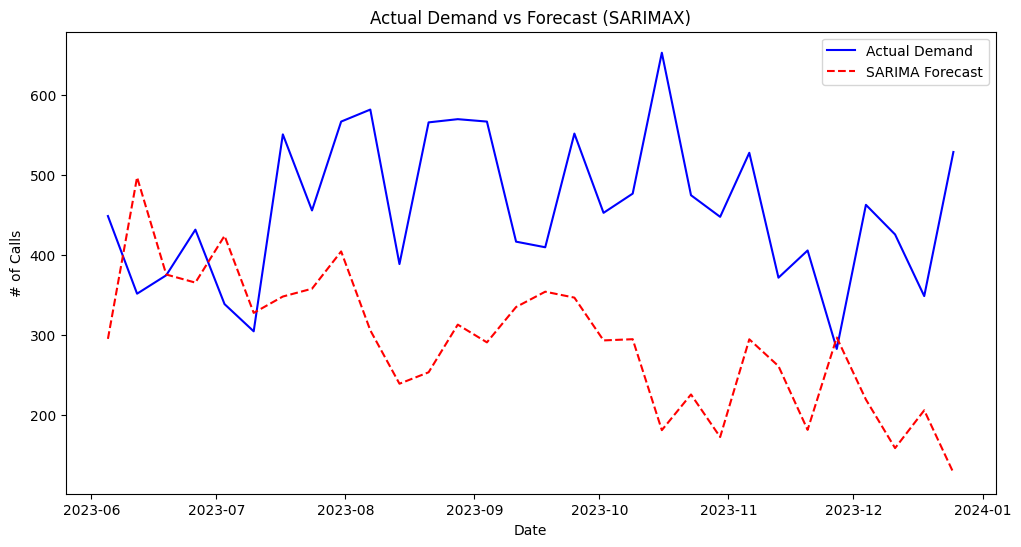

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(ambulance_test_df['date'], ambulance_test_df['calls'], label='Actual Demand', color='blue')
plt.plot(predicted_mean.index, predicted_mean, label='SARIMA Forecast', color='red', linestyle='--')
plt.title("Actual Demand vs Forecast (SARIMAX)")
plt.xlabel("Date")
plt.ylabel("# of Calls")
plt.legend()
plt.show()

In [ ]:
mae = mean_absolute_error(ambulance_test_df['calls'], predicted_mean.values)
print("MAE on test data:", mae)

MAE on test data: 184.0077317600946


#### 1. Which forecasting method was better?

Triple exponential smoothing resulted in a lower MAE with 139.68 compared to SARIMAX with a MAE of 184.01. The primary reason for this is likely the stability of the 52-week seasonal cycle. TES excels at isolating level, trend, and seasonal components directly, whereas SARIMA’s complexity may have led to "over-fitting" or poor convergence on this specific dataset.

#### 2. Any outliers that impacted forecast accuracy?

In [ ]:
# We use the forecast variable from TES
test_residuals = ambulance_test_df['calls'] - forecast

Q1_t = test_residuals.quantile(0.25)
Q3_t = test_residuals.quantile(0.75)
IQR_t = Q3_t - Q1_t

lower_t = Q1_t - 1.5 * IQR_t
upper_t = Q3_t + 1.5 * IQR_t

test_outliers = ambulance_test_df[(test_residuals < lower_t) | (test_residuals > upper_t)]

print("Outliers found in the 30-week Test Data:")
print(test_outliers)

Outliers found in the 30-week Test Data:
Empty DataFrame
Columns: [date, calls]
Index: []


/var/folders/ht/879gb0f17j9__nx8w63714yw0000gn/T/ipykernel_17977/87858944.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_outliers = ambulance_test_df[(test_residuals < lower_t) | (test_residuals > upper_t)]


No outliers were found in the 30-week test period using our TES forecast and IQR calculations. This indicates that during the 30 weeks test data, the ambulance call volume followed our TES model's predicted patterns without any extreme or unexplained shocks.

#### 3. Which method would your ecommend using for your particular use case and why?

For the project report, I recommend TES as the optimal forecasting method for this application. Quantitatively, it outperformed SARIMAX by achieving a significantly lower Mean Absolute Error (MAE) of 139.68 compared to 184.01, representing a 24% improvement in accuracy. Qualitatively, TES seems pretty similar to SARIMAX. From an Industrial Engineering perspective, this model provides a more reliable and interpretable framework for capacity planning, offering clear "levers" through its $\alpha, \beta,$ and $\gamma$ parameters for future sensitivity analysis and staffing adjustments.

#### 4. What are the strengths and weaknesses of models? What external info. would have helped improve forecast accuracy?

While TES is the best univariate model, accuracy could be further improved by incorporating other variables like weather forecasts or public health alerts. These would help explain the random spikes that even the best seasonal model cannot predict.